In [3]:
from lmfit import minimize, Parameters # Parameter, report_fit

In [4]:
import numpy as np
import xsimlab as xs
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [27]:
plt.rcParams['figure.figsize'] = [15, 10]

### create minimal ODE system example: 
## Phytoplankton growing in chemostat (constant flowthrough)

In [28]:
halfsat = 0.5
flow = 0.3
N0 = 2
init = [1,0.01]

def chemostat(t,x):
    
    N,P = x
    
    nutuptake = N / (halfsat + N) 
    
    dPdt = nutuptake * P - flow * P
    
    dNdt = flow * N0 - nutuptake * P  - flow * N
    
    return [dNdt, dPdt]

## Solve this model with xsimlab (time-explicit)

In [33]:
@xs.process
class MODEL:
    x = xs.variable(dims='x', intent='in')
    out = xs.variable(dims=('x'),intent='out')
    outflux = xs.variable(dims=('x'),intent='out')
    
    def initialize(self):
        self.out = init
        self.time = 0
    
    @xs.runtime(args='step_delta')
    def run_step(self,dt):
        # need to convert fluxes to correct time step with dt
        self.outflux = chemostat(self.time, self.out) * dt
        # keep track of timestep for forcing (+ other time dep. processes)
        self.time += dt
    
    def finalize_step(self):
        self.out = np.array(self.out) + np.array(self.outflux)

In [34]:
MOD = xs.Model({'m':MODEL})

indat = xs.create_setup(
  model=MOD,
     clocks={
         'time': np.linspace(0,40,1000)
     },
     input_vars={
         'm__x':('x',['N','P'])
     },
     output_vars={
        'm__x': None,
        'm__out':'time',
        'm__outflux':'time'
     }  
)

In [35]:
out = indat.xsimlab.run(model=MOD).set_index(index='m__x')
out

<xarray.Dataset>
Dimensions:     (index: 2, time: 1000, x: 2)
Coordinates:
  * time        (time) float64 0.0 0.04004 0.08008 0.1201 ... 39.92 39.96 40.0
  * index       (index) object 'N' 'P'
Dimensions without coordinates: x
Data variables:
    m__out      (time, x) float64 1.0 0.01 1.012 0.01015 ... 1.786 0.2143 1.786
    m__outflux  (time, x) float64 0.01175 0.0001468 ... -1.423e-08 8.3e-08

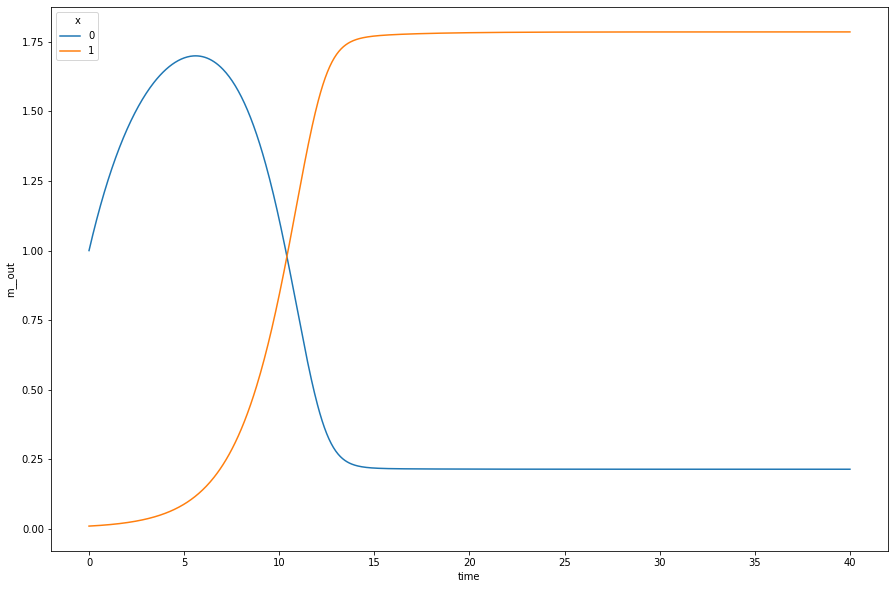

In [36]:
out.m__out.plot.line(x='time')

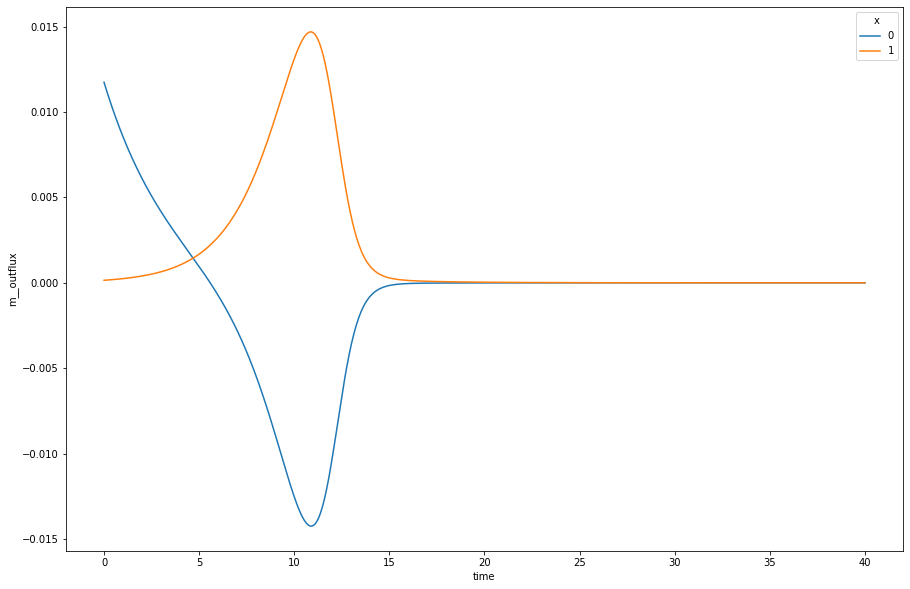

In [37]:
out.m__outflux.plot.line(x='time')